In [1]:
import sys
sys.path.append('..')
import copy
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm

import utils

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set Base Path: your zip file should be unzipped here

In [6]:
base_path="../data/"

### Set parameters

In [7]:
n=64 #[4,8,16,32,64,128,256,512,1024,2048]
test_seed=415143

In [8]:
exp_dir=os.path.join(base_path,f"default_long_rope_only/default_long_rope_only/n={n}")
config_file=os.path.join(exp_dir,"config.yaml")
config=utils.load_config(config_file)
config["num_workers"]=1
k=config["data_params"]["ks"][0]

### Make dataloaders

In [9]:
#In distribution dataloader
dl_ID=utils.get_dataloader(config)

#Out of distribution dataloader
config_ood=copy.deepcopy(config)
np.random.seed(test_seed)
for i in range(n):#change all random states for the transition matrices
    config_ood["data_params"]['transition_paramss'][i]["random_state"]=np.random.randint(1000000)
dl_OOD=utils.get_dataloader(config_ood)

### Get some example data

In [10]:
x_ID=next(iter(dl_ID))[0]#returns ((batch_size,seq_len),None) #None is for the loss mask, which we don't use, so select [0]
x_OOD=next(iter(dl_OOD))[0]
x_ID,x_OOD=x_ID.to(device),x_OOD.to(device)
x_ID.shape,x_OOD.shape

(torch.Size([128, 512]), torch.Size([128, 512]))

### Now load the model

In [11]:
#Model
model=utils.get_model(config,device=device)
ckpt_paths=utils.get_ckpt_paths(exp_dir)
ckpt_paths.keys()

dict_keys([49, 58, 68, 80, 93, 109, 128, 149, 175, 204, 239, 280, 327, 383, 448, 524, 613, 717, 839, 981, 1147, 1342, 1570, 1836, 2148, 2512, 2939, 3437, 4020, 4702, 5500, 6433, 7525, 8801, 10294, 12040, 14083, 16472, 19266, 22534, 26357, 30828, 36057, 42174, 49328, 57696, 67482, 78930, 92318, 107978])

### ID and OOD Loss

In [12]:
steps=[]
loss_IDs=[]
loss_OODs=[]
for step,ckpt_path in tqdm.tqdm(ckpt_paths.items(),total=len(ckpt_paths)):
    model.load_state_dict_nc(torch.load(ckpt_path,weights_only=False))#nc means no_compile, just avoiding a small conflcit between weight names
    model.eval()
    with torch.no_grad():
        loss_ID=model.get_loss(x_ID)
        loss_OOD=model.get_loss(x_OOD)
    steps.append(step)
    loss_IDs.append(loss_ID.item())
    loss_OODs.append(loss_OOD.item())
loss_IDs=np.array(loss_IDs)
loss_OODs=np.array(loss_OODs)

100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


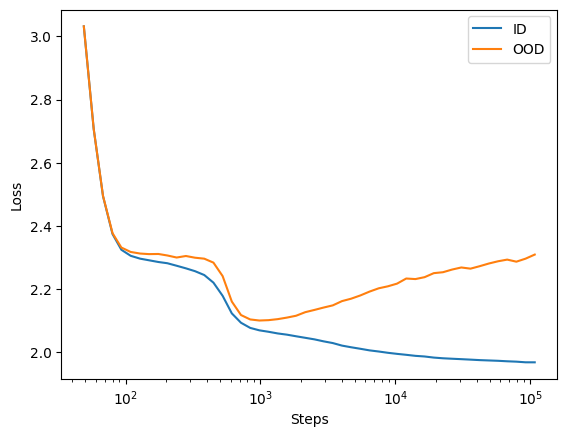

In [13]:
plt.plot(steps,loss_IDs,label="ID")
plt.plot(steps,loss_OODs,label="OOD")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.xscale("log")
plt.legend()

### Model's transition matrix given context

In [49]:
model.load_state_dict_nc(torch.load(ckpt_paths[107978],weights_only=False))

In [50]:
#get a single dataset out of n transition matrices
dataset_ID_single=dl_ID.dataset.datasets[0]
dataset_OOD_single=dl_OOD.dataset.datasets[0]
T_ID_single=dataset_ID_single.T
T_OOD_single=dataset_OOD_single.T

In [51]:
#this is just some dirty code to collect context ending with a certain token
context_ID_single=dict([state,[]] for state in range(k))
context_OOD_single=dict([state,[]] for state in range(k))
n_batch_per_state=15
# sample until full
while not all(len(context_ID_single[state])==n_batch_per_state for state in range(k)):
    x_ID_single=dataset_ID_single.get_data()
    last=x_ID_single[-1].item()
    if len(context_ID_single[last])<n_batch_per_state:
        context_ID_single[last].append(x_ID_single)
while not all(len(context_OOD_single[state])==n_batch_per_state for state in range(k)):
    x_OOD_single=dataset_OOD_single.get_data()
    last=x_OOD_single[-1].item()
    if len(context_OOD_single[last])<n_batch_per_state:
        context_OOD_single[last].append(x_OOD_single)
context_ID_single={state:torch.stack(context_ID_single[state]) for state in range(k)}
context_OOD_single={state:torch.stack(context_OOD_single[state]) for state in range(k)}

In [52]:
T_model_ID=[]
T_model_OOD=[]
for state,context in context_ID_single.items():
    context=context.to(device)
    with torch.no_grad():
        last_next_logits=model(context)[:,-1,:10]#the last :10 is to constrain the token space, see below
    probs=torch.softmax(last_next_logits,dim=-1).mean(0).cpu()
    T_model_ID.append(probs)
for state,context in context_OOD_single.items():
    context=context.to(device)
    with torch.no_grad():
        last_next_logits=model(context)[:,-1,:10]#the last :10 is to constrain the token space, see below
    probs=torch.softmax(last_next_logits,dim=-1).mean(0).cpu()
    T_model_OOD.append(probs)
T_model_ID=torch.stack(T_model_ID,0)
T_model_OOD=torch.stack(T_model_OOD,0)
T_model_ID.shape,T_model_OOD.shape

(torch.Size([10, 10]), torch.Size([10, 10]))

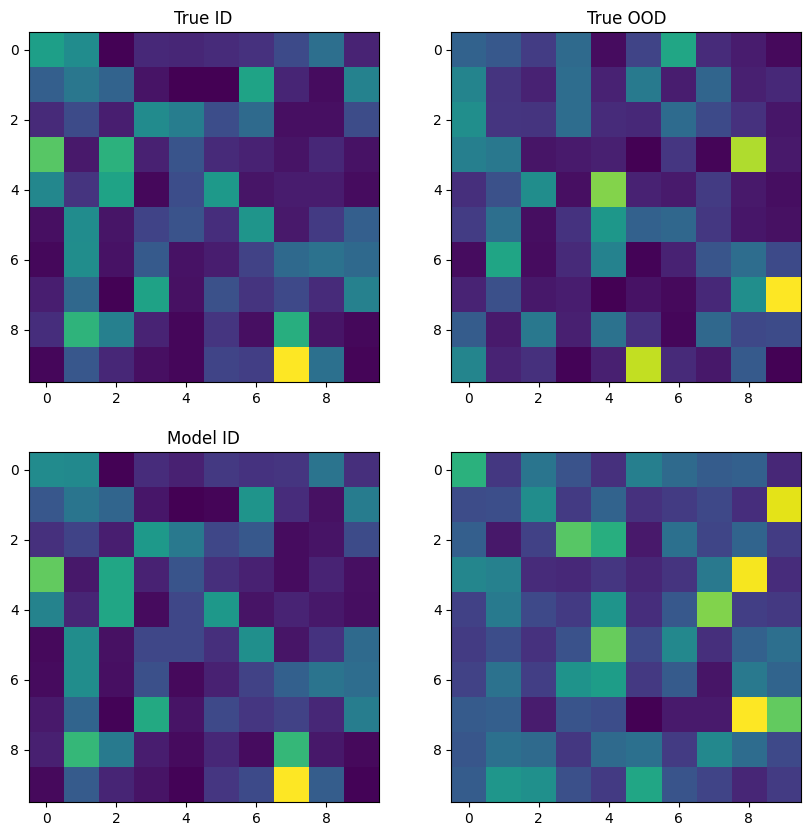

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(T_ID_single,cmap="viridis")
plt.title("True ID")
plt.subplot(2,2,2)
plt.imshow(T_OOD_single,cmap="viridis")
plt.title("True OOD")
plt.subplot(2,2,3)
plt.imshow(T_model_ID,cmap="viridis")
plt.title("Model ID")
plt.subplot(2,2,4)
plt.imshow(T_model_OOD,cmap="viridis")
plt.title("Model OOD")

### A few points:
- There are 676 tokens, but only 10 tokens are used. I recommend take only the first 10 token logits BEFORE the softmax for analysis. Of course, these probabilities will be negligible very early in the training
- Dataloader might be slow. It wasn't the constraining factor during training though.
- The steps are linear when sqrt-ed
- Tell me if you need code for KL divergence, etc.

In [39]:
model

Transformer(
  (transformer): Transformer(
    (transformer): ModuleDict(
      (wte): Embedding(676, 64)
      (wpe): None
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-1): 2 x TransformerBlock(
          (ln_1): LayerNorm()
          (attn): SelfAttentionBlock(
            (c_attn): Linear(in_features=64, out_features=192, bias=True)
            (c_proj): Linear(in_features=64, out_features=64, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLPBlock(
            (c_fc): Linear(in_features=64, out_features=256, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=256, out_features=64, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=64, out_features=676, bias=Fals

In [42]:
ckpts=utils.get_ckpt_paths(exp_dir)
ckpts

{49: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=49.pth',
 58: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=58.pth',
 68: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=68.pth',
 80: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=80.pth',
 93: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=93.pth',
 109: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=109.pth',
 128: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=128.pth',
 149: '../data/markov_mixture/final_v1/default_long_rope_only/default_long_rope_only/n=64/checkpoints/ckpt_step=149.pth',
 175: '../data/markov_mixture/fina